# DEPENDENCIES FOR ALL SECTIONS

In [6]:
import importlib
from makemore.prepare_data import generate_training_data
import makemore.neural_network
importlib.reload(makemore.neural_network)
from makemore.neural_network import NeuralNetwork, TrainingParams, InitializationType
import random 
from makemore.prepare_data import generate_character_mapping
import matplotlib.pyplot as plt
import numpy as np
import torch
from makemore.neural_network_bn import NeuralNetworkBN


with open('data/names.txt', encoding='utf-8') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

character_map = generate_character_mapping(names)

random.seed(42)
random.shuffle(names)

n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

X_train,Y_train  = generate_training_data(names[:n1],4)
X_val,Y_val = generate_training_data(names[n1:n2],4)
X_test,Y_test = generate_training_data(names[n2:],4)

# Playing with the initial loss

[Chapter in Youtube](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4&t=259s)

What to do we expect the loss to be at initialization? 

- Our loss function right now is the negative log likelihood average function.  If the probability is close to 0, the loss is exponentially high. 

In [7]:
nn_bad_initialization = NeuralNetwork(context_size=4,hidden_layer_neurons=150,letter_embedding_dimensions=3, print_flag=True, initialization_type=InitializationType.no_fixes)
nn_bad_initialization.train(X_train,Y_train, training_params= TrainingParams(iterations=1000, batch_size=50, learning_rate=lambda _: 0.1))


Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 6108
Start training
Loss after 1 epochs: 24.230430603027344


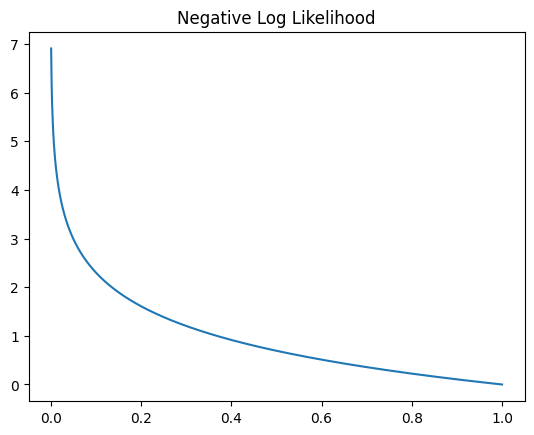

In [ ]:
# visualize negativ log likelyhood with matplotlib

sample_xs = np.linspace(0.001, 1, 1000)
sample_ys = [-np.log(x) for x in sample_xs]
plt.plot(sample_xs,sample_ys)
plt.title("Negative Log Likelihood")
plt.show()


- Considering that we have 27 characters to be predicted, the average loss is a bit too high. 
- With uniform prediction we would have **(4 %/0.04)** chance of making the right guess. 
- From negative log likelihood perspectice, this should be average value around 3 visually looking

An example of this

In [ ]:
-np.log(1/27)

3.295836866004329

Reallity hits us

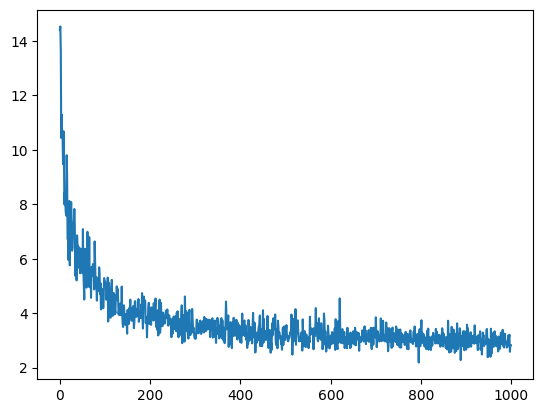

In [ ]:
plt.plot(nn_bad_initialization.losses)

So why is it around 25-27 in the beginning of training in this case?

- We are randomly initializing the params. The logits generated are then run through sigmoid function which in itself actually powers the differences between predictions. If we are wrong, we are wrong powerfully and that is powered by out cost function: negative log likelihood function (visualized above)

So, how would you solve this?

- Perhaps initialize all parameters uniformly. So every possibility is equal. 


In [ ]:

nn = NeuralNetwork(context_size=4,hidden_layer_neurons=150,letter_embedding_dimensions=3, print_flag=True,initialization_type=InitializationType.avoid_being_confidently_wrong)
nn.train(X_train,Y_train, training_params= TrainingParams(iterations=1000, batch_size=50, learning_rate=lambda _: 0.1))
for i in range(1):
    print(nn.generate_name())

Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 6108
Start training
Loss after 1 epochs: 3.311779022216797
Loss after 334 epochs: 3.3658621311187744
Loss after 667 epochs: 3.4773428440093994
Loss after 1000 epochs: 3.581526756286621
NN_4_150_3 loss:after 1000 epochs: 2.6321463584899902
[9, 22, 5, 0]


Muchos bette

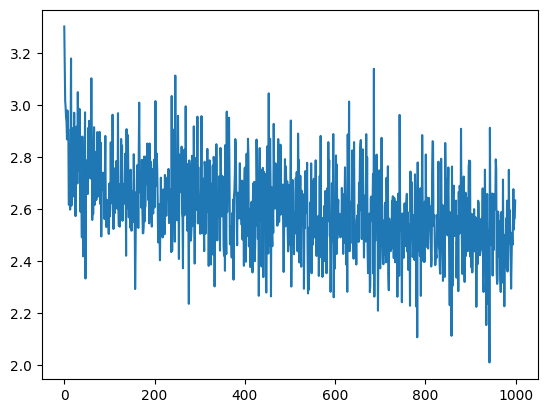

In [ ]:
plt.plot(nn.losses)

# Tanh function result

First, lets look at tanh function

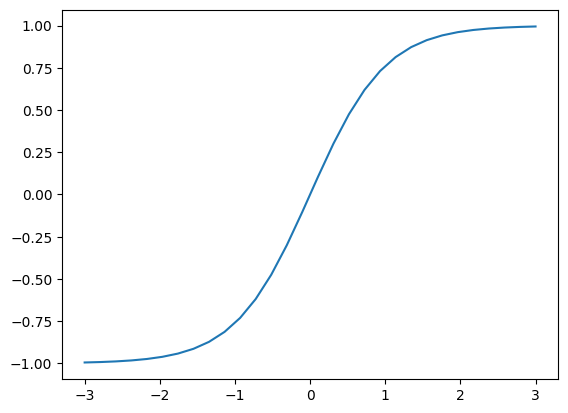

In [ ]:
tan_graph = torch.linspace(-3,3,30).tanh()
plt.plot(torch.linspace(-3,3,30),tan_graph)

As we can see the tanh function squashes outputs to -1..1 interval. This means if input size is bigger than some theshold, then output is very close to -1/1. We can see it in the nn initialization as well.

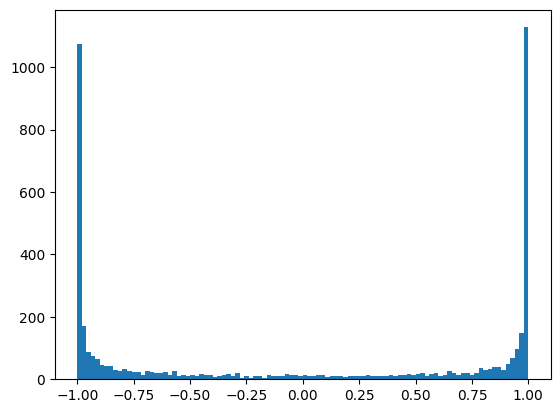

In [ ]:
minibatch = torch.randint(0, len(X_train), (30,))
h = (nn.c[X_train[minibatch]].view(-1, nn.context_size * nn.letter_embedding_dimensions) @ nn.w1 + nn.b1).tanh()
histogram_plot = plt.hist(h.view(-1).tolist(), bins=100)


If we look at the input to the tanh function, the large set of outputs as -1/1 really makes sense. 

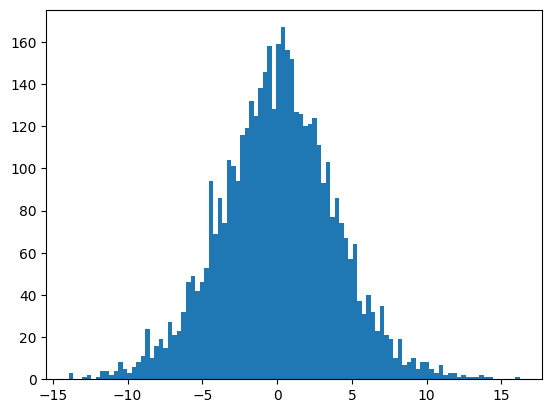

In [ ]:
minibatch = torch.randint(0, len(X_train), (30,))
pre_h = nn.c[X_train[minibatch]].view(-1, nn.context_size * nn.letter_embedding_dimensions) @ nn.w1 + nn.b1
histogram_plot = plt.hist(pre_h.view(-1).tolist(), bins=100) 

According to Andrej Karpahty this is not good, why?

- If we look at tanh function and its gradient from the previous micrograd lecture, when the outcome of tanh function is 1 or -1 then the tanh gradient will become 0 and will make all the upstream parameters gradients also 0. If it happens to all data, then we have something called the dead gradient problem in our hands which means tha gradient is never updated with any data. 


~~~python
def tanh(self): # https://wikimedia.org/api/rest_v1/media/math/render/svg/b8dc4c309a551cafc2ce5c883c924ecd87664b0f
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
        self.grad += (1 - out.data**2) * out.grad
        self._gradient_updates+=1

    out._backward = _backward     
    return out
~~~

Showing locations where the tanh output equals 1 which means the gradient would equal to 0.  The white part in this graph is where h (outcome of tanh) is greater than 0.99

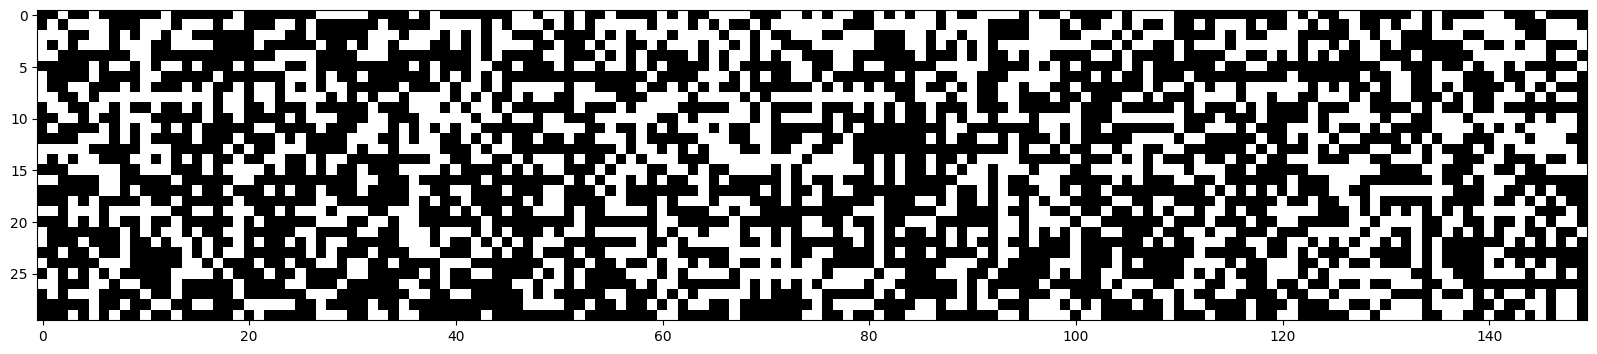

In [ ]:
plt.figure(figsize=(20,10))
p=plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

Let's now look into the possibility of making the input to tanh squashed down

Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 6108


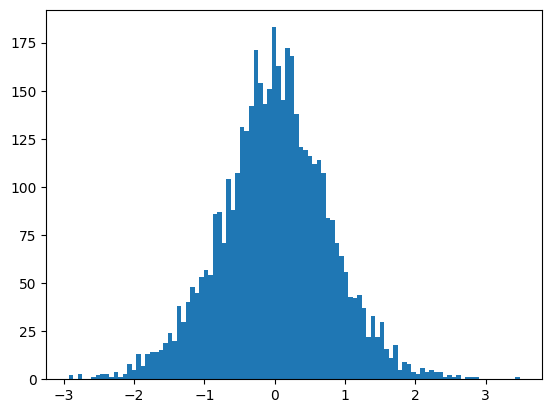

In [ ]:
nn = NeuralNetwork(context_size=4,hidden_layer_neurons=150,letter_embedding_dimensions=3,print_flag=True,initialization_type=InitializationType.squash_h)
pre_h = nn.c[X_train[minibatch]].view(-1, nn.context_size * nn.letter_embedding_dimensions) @ nn.w1 + nn.b1

histogram_plot = plt.hist(pre_h.view(-1).tolist(), bins=100) 

Lets look at the tanh outcome histogram. Now the outcome is seldom 1 which means we don't also have the dead gradient problem in our hands. 

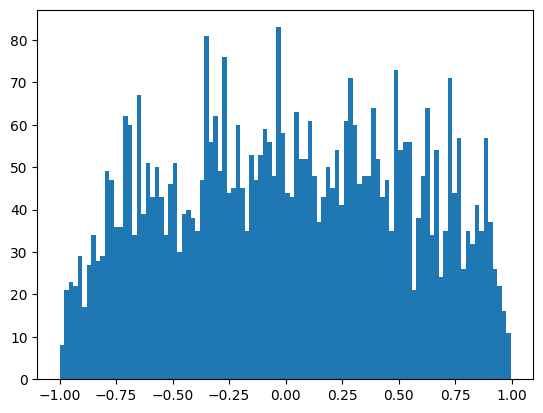

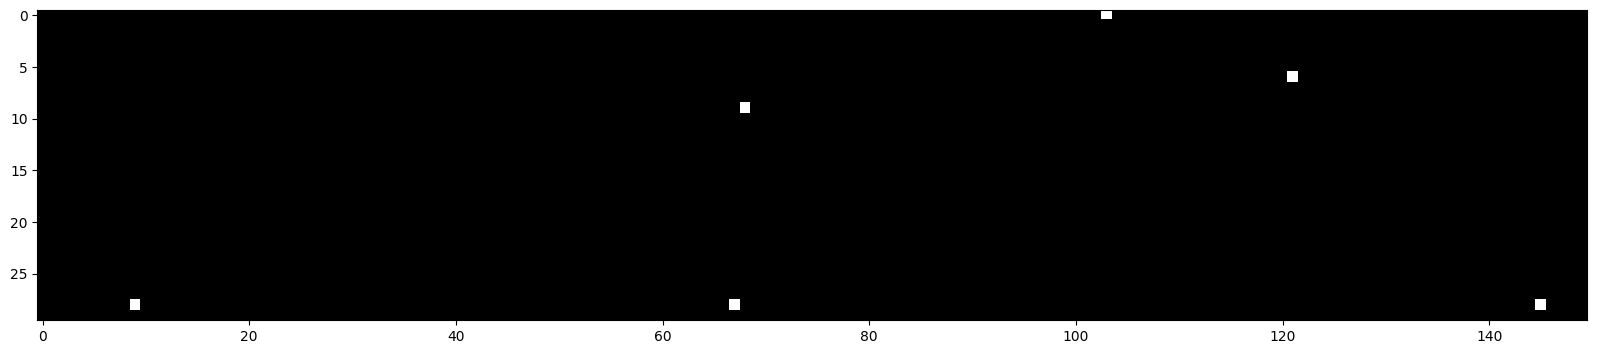

In [ ]:

minibatch = torch.randint(0, len(X_train), (30,))
h = (nn.c[X_train[minibatch]].view(-1, nn.context_size * nn.letter_embedding_dimensions) @ nn.w1 + nn.b1).tanh()
histogram_plot = plt.hist(h.view(-1).tolist(), bins=100)

plt.figure(figsize=(20,10))
p=plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

As the above picture now is mostly black, we don't have tanh outcomes with result 1

# Kaiming Method for keeping the outputs with same standard 


Added to NN class initialization normalizer which makes the initial layer output follow normal distribution.
~~~python 
self.w1 = torch.randn(self.letter_embedding_dimensions*self.context_size,self.hidden_layer_neurons,generator=self.g) * ((5/3)/(self.letter_embedding_dimensions*self.context_size)**0.5)
~~~

$$w_1\frac{5}{3}\sqrt{\text{Number of input parameters}}$$


## NOTES 

- Idea is to apply normalization for each layers **initialization** weights to keep the outputs also to have std 1. 
- Could be applied do every layer: https://chatgpt.com/share/3a5d4861-e6b2-47cf-8db6-4b531652d0f7

## REFS 

- https://youtu.be/P6sfmUTpUmc?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=1908  -- Talks about Kaiming init and applying it.






# Comparison of 4 initializations

In [ ]:
# ## Slow -- takes a minute or two to run

# assigned_context_size = 4
# letter_embedding_dimensions = 100
# hidden_layer_neurons = 150


# neural_networks = {
#     "no initiialization fixes": NeuralNetwork(context_size=assigned_context_size,hidden_layer_neurons=hidden_layer_neurons,letter_embedding_dimensions=letter_embedding_dimensions, print_flag=False, initialization_type=InitializationType.no_fixes),
#     "avoid being confidently wrong": NeuralNetwork(context_size=assigned_context_size,hidden_layer_neurons=hidden_layer_neurons,letter_embedding_dimensions=letter_embedding_dimensions, print_flag=False, initialization_type=InitializationType.avoid_being_confidently_wrong),
#     "squash h": NeuralNetwork(context_size=assigned_context_size,hidden_layer_neurons=hidden_layer_neurons,letter_embedding_dimensions=letter_embedding_dimensions, print_flag=False, initialization_type=InitializationType.squash_h),
#     "kaiming": NeuralNetwork(context_size=assigned_context_size,hidden_layer_neurons=hidden_layer_neurons,letter_embedding_dimensions=letter_embedding_dimensions, print_flag=False, initialization_type=InitializationType.kaiming_tanh)
# }    

# for name, nn in neural_networks.items():
#     nn.train(
#         X_train,
#         Y_train, 
#         training_params= TrainingParams(iterations=1000, batch_size=50, learning_rate=lambda _: 0.1)
#     )
#     loss = nn.calculate_loss(X_val,Y_val)

#     print(f"Loss for {name}: {loss}")
#     plt.plot(np.log(nn.losses), label=name, scaley=True)

# plt.legend()



# BATCH NORMALIZATION

We don't want to have the preactiviation function result to be too high or too low.

- If it is too close to zero then tanh function is not doing anything (Andrej Karpathy said this) In my opinion this will quickly be fixed by the gradient descent as gradient will be high.
- If it is too high, then the tanh gradient is 0 and we have the dead gradient problem in our hands.

## WHAT BATCH NORMALIZATION DOES

- Makes all linear activations Standardized Gaussian modified by bngain, bnbias


In batch normalization we will take the h preactivation function and normalize it by substracting the mean and dividing by batch std for other preactivations. 
In addition, we multiply the result by each neurons bngain and add to it bnbias. This allows some neurons to be more active than others and shift/shape the layer in certain form. The normalization is on completely differentiable operation.


## THE VALUE OF BATCH NORMALIZATION


- Ensures that the distribution of each layer’s inputs remains stable during training, even as the parameters of the previous layers change.
  - This stability (through Gaussian) will have the training to converge quicker because the training step size does not need to vary that crasily due to inputs being on same scale I can't really explain this yet well but it sound intuitive. If every layer in NN is scaled roughly in the same proportions, the multilayer training does not probably need to do overcompensation between different layers. 
- Adds Random Noise through Batch Statistics (Regularization) prevents overfitting
 



## BATCH NORMALIZATION IS A COMPLETELY DIFFERENTIABLE OPERATION

It is basically a collection of divisions and additions which are completely differentiable. This means, having this layer inbetween we can continue backpropagating easily.

## BATCH NORMALIZATION + BNGAIN AND BNBIAS (SCALE AND SHIFT)

bngain and bnbias will be both trainable parameters that allow to make some neurons more "active" than others.  

## TERRIBLE COST OF BATCH NORMALIZATION

+ Coupling batches -- each

## QUESTIONS 

How do we do non-training forward pass without having the batch to normalize the output?
- We could take a random batch and use that to normalize the output.
- We could also add to each neuron some value that could be used to normalize later on <-- CORRECT
- We can do nothing? Normalization is important for training but for separate forward pa ss

## RUNNING BATCH NORM 

In [ ]:
nn_batch_norm = NeuralNetworkBN(context_size=4,hidden_layer_neurons=150,letter_embedding_dimensions=3, print_flag=True)


Context size: 4
Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Shape of bngain: torch.Size([150])
Shape of bnbias: torch.Size([150])
Total parameters currently in NN 6408


In [ ]:

minibatch = torch.randint(0,X_train.shape[0],(10,))
# LINEAR LAYER
hpreact = (nn_batch_norm.c[X_train[minibatch]].view(-1, nn_batch_norm.context_size * nn_batch_norm.letter_embedding_dimensions) @ nn_batch_norm.w1 + nn_batch_norm.b1)   
# For each training example we willhave 1 extra row in the resulting matrix and for each neuron we will have 1 extra column. We have currently 10 training examples
print(hpreact.shape)
# For each Neuron we get the mean and std of the activations for the minibatch
print(hpreact.mean(0, keepdim=True).shape)
print(hpreact.std(0, keepdim=True).shape)

torch.Size([10, 150])
torch.Size([1, 150])
torch.Size([1, 150])


In [ ]:

nn_batch_norm.train(X_train,Y_train, training_params= TrainingParams(iterations=1000, batch_size=50, learning_rate=lambda _: 0.1))